In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [2]:
# Step 2: Load the Kaggle dataset
file_path = 'C:/Users/parva/Desktop/ML_Project/archive/twitter_training.csv'
df = pd.read_csv(file_path)
#define the columns of the dataset
df.columns = ['tweet id','entity','sentiment','Tweet content']
# Define the valid sentiment labels
valid_sentiments = ['Positive', 'Negative', 'Neutral']
# Filter out tweets with 'irrelevant' sentiment labels
df = df[df['sentiment'].isin(valid_sentiments)]

# Debug: Confirm only valid sentiments remain
print(f"Unique sentiments after filtering: {df['sentiment'].unique()}")
print(f"Remaining tweets: {len(df)}")

# Display the first few rows of the dataset
print(df.head())

Unique sentiments after filtering: ['Positive' 'Neutral' 'Negative']
Remaining tweets: 61691
   tweet id       entity sentiment  \
0      2401  Borderlands  Positive   
1      2401  Borderlands  Positive   
2      2401  Borderlands  Positive   
3      2401  Borderlands  Positive   
4      2401  Borderlands  Positive   

                                       Tweet content  
0  I am coming to the borders and I will kill you...  
1  im getting on borderlands and i will kill you ...  
2  im coming on borderlands and i will murder you...  
3  im getting on borderlands 2 and i will murder ...  
4  im getting into borderlands and i can murder y...  


In [3]:
def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    return text.lower()  # Convert to lowercase

df['cleaned_text'] = df['Tweet content'].apply(clean_tweet)


In [4]:
label_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': 2}
df['label'] = df['sentiment'].map(label_mapping)

In [5]:
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=10000)  # Set a vocabulary size (e.g., top 10,000 words)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure equal length
max_len = 50  # Define a maximum length for sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [7]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)


In [8]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
vocab_size = 10000  # Match the vocabulary size used in the tokenizer
embedding_dim = 128  # Size of word embeddings
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    LSTM(units=64, return_sequences=True),  # First LSTM layer
    Dropout(0.2),  # Regularization
    LSTM(units=64),  # Second LSTM layer
    Dense(units=32, activation='relu'),
    Dropout(0.2),
    Dense(units=3, activation='softmax')  # 3 classes: Positive, Negative, Neutral
])

# Compile the model - old
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


c:\Users\parva\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [9]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# Define the optimizer
optimizer = Adam(learning_rate=0.001)  # Start with a small learning rate

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model with the scheduler
history = model.fit(
    X_train_pad, 
    y_train_enc, 
    validation_data=(X_test_pad, y_test_enc), 
    batch_size=32, 
    epochs=10, 
    callbacks=[lr_scheduler]  # Include the learning rate scheduler here
)


Epoch 1/10
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step - accuracy: 0.3967 - loss: 1.0851 - val_accuracy: 0.4989 - val_loss: 1.0028 - learning_rate: 0.0010
Epoch 2/10
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.4826 - loss: 1.0251 - val_accuracy: 0.5155 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 3/10
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.5313 - loss: 0.9442 - val_accuracy: 0.6295 - val_loss: 0.7646 - learning_rate: 0.0010
Epoch 4/10
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.7010 - loss: 0.6729 - val_accuracy: 0.7856 - val_loss: 0.5303 - learning_rate: 0.0010
Epoch 5/10
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.8558 - loss: 0.3860 - val_accuracy: 0.8236 - val_loss: 0.4652 - learning_rate: 0.0010
Epoch 6/10
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.9024 - loss: 0.2548 - val_accuracy: 0.8458 - val_loss: 0.4265 - learning_rate: 0.0010
Epoch 7/10
1543/1543 ━━━━━━━━━━━━━━━━━━━━ 54s 35ms/step - accura

In [10]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_pad, y_test_enc, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.8608 - loss: 0.5194
Test Loss: 0.49826061725616455
Test Accuracy: 0.8667638897895813


386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step
Confusion Matrix:
[[3296  225  157]
 [ 422 3589  158]
 [ 409  273 3810]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.84      3678
           1       0.88      0.86      0.87      4169
           2       0.92      0.85      0.88      4492

    accuracy                           0.87     12339
   macro avg       0.87      0.87      0.87     12339
weighted avg       0.87      0.87      0.87     12339



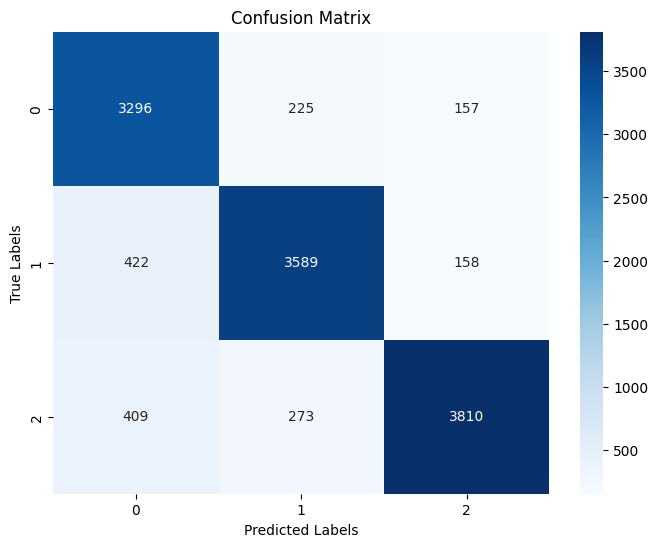

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Predict on the test set
y_pred_prob = model.predict(X_test_pad)  # Get prediction probabilities
y_pred = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class predictions

# Step 2: Confusion Matrix
conf_matrix = confusion_matrix(y_test_enc, y_pred)

# Print Confusion Matrix
print("Confusion Matrix:")
print(conf_matrix)

# Step 3: Classification Report
class_report = classification_report(y_test_enc, y_pred)
print("\nClassification Report:")
print(class_report)

# Step 4: Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()